In [1]:
#!/usr/bin/python3
# coding: utf-8
# prefectures

In [2]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
import json
import matplotlib
import numpy as np
import os
import pandas as pd
from PIL import Image
import sys
if "ipy" not in sys.argv[0]:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly
import plotly.express as px
import plotly.tools as tls
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as offline
from plotly.subplots import make_subplots
if "ipy" in sys.argv[0]:
    offline.init_notebook_mode()
from sklearn.neighbors import LocalOutlierFactor
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed, json2nparr, code2int, age2int, \
    get_populations, get_os_idx_of_arr, dump_val_in_arr, \
    calc_last1w2w_dif, create_basic_scatter_figure, \
    show_and_save_plotly

In [3]:
populations = get_populations()
#print(populations)

All population in Japan: 127094745


In [4]:
# 全国情報
ogiwara_uri = "https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/"
pref_file = "prefectures.csv"
download_if_needed(ogiwara_uri, pref_file)

In [5]:
offsets = dict(
    year  = 0, # 年
    month = 1, # 月
    day   = 2, # 日
    st_ja = 3, # 都道府県
    st_en = 4, # state
    posis = 5, # 陽性者数
    tests = 6, # 検査数
    hospi = 7, # hospitalized
    serio = 8, # serious
    disch = 9, # discharged
    death =10, # deaths
    ern   =11, # Effective Reproduction Number
)

In [6]:
dt_start = dt.strptime("2020/2/8", "%Y/%m/%d") # 統計開始日
dt_now   = dt.now() # 現在日時
dt_delta = (dt_now - dt_start).days # 差分
n_states = 47 # 都道府県数
erns = [] # 実効再生産数
poss = [] # 陽性者数
test = [] # 検査数
for i in np.arange(dt_delta):
    erns.append(np.zeros(n_states+1).tolist())
    poss.append(np.zeros(n_states+1).tolist())
    test.append(np.zeros(n_states+1).tolist())
    test[i][0] = poss[i][0] = erns[i][0] = i

In [7]:
with codecs.open("prefectures.csv", encoding='utf-8') as f:
    l = f.readline()
    cnt = 0
    while l:
        l = f.readline().replace("\r\n", "").rstrip()
        elems = l.split(',')
        if len(elems) < 2:
            continue
        dt_idx  = (dt(int(elems[0]), int(elems[1]), int(elems[2])) - dt_start).days
        st_name = elems[offsets['st_en']]
        st_idx  = populations[st_name]['code']
        erns[dt_idx][st_idx] = blank2zero(elems[offsets['ern']])
        poss[dt_idx][st_idx] = blank2zero(elems[offsets['posis']])
        tested = blank2zero(elems[offsets['tests']])
        if tested > 0:
            test[dt_idx][st_idx] = tested
        cnt += 1
print("Load {} lines.".format(cnt))

Load 10383 lines.


In [8]:
erns = np.array(erns)
poss = np.array(poss)
test = np.array(test)

In [9]:
os_idx = get_os_idx_of_arr(erns, dt_delta)
latest_erns = erns[os_idx] # 最新の実効再生産数
dump_val_in_arr(populations, latest_erns, "最新の実効再生産数")

Data offset index: -1
最新の実効再生産数: 北海道=1.0 青森=8.5 岩手=1.0 宮城=1.1 秋田=0.3 山形=1.6 福島=1.2 茨城=0.6 栃木=0.9 群馬=0.7 埼玉=1.2 千葉=0.9 東京=1.1 神奈川=1.1 新潟=0.8 山梨=0.6 長野=0.6 岐阜=1.8 静岡=0.5 愛知=1.0 三重=0.5 富山=0.0 石川=4.8 福井=0.4 滋賀=1.3 京都=2.0 大阪=1.1 兵庫=0.9 奈良=1.4 和歌山=5.5 鳥取=0.0 島根=0.0 岡山=1.1 広島=0.8 山口=0.5 徳島=0.0 香川=0.0 愛媛=0.0 高知=0.0 福岡=1.6 佐賀=0.5 長崎=1.3 熊本=1.2 大分=0.0 宮崎=0.0 鹿児島=0.5 沖縄=0.9 


In [10]:
os_idx = get_os_idx_of_arr(poss, dt_delta)
latest_poss = poss[os_idx] # 最新の感染者数
dump_val_in_arr(populations, latest_poss, "最新の感染者数", 0)

Data offset index: -1
最新の感染者数: 北海道=2430 青森=57 岩手=25 宮城=504 秋田=59 山形=81 福島=332 茨城=719 栃木=453 群馬=764 埼玉=5234 千葉=4430 東京=28420 神奈川=7758 新潟=180 山梨=199 長野=320 岐阜=640 静岡=572 愛知=5596 三重=544 富山=422 石川=787 福井=249 滋賀=520 京都=1898 大阪=11361 兵庫=2946 奈良=607 和歌山=254 鳥取=36 島根=140 岡山=168 広島=644 山口=209 徳島=149 香川=96 愛媛=115 高知=140 福岡=5125 佐賀=249 長崎=241 熊本=726 大分=158 宮崎=366 鹿児島=456 沖縄=2826 


In [11]:
diff1w_poss, diff2w_poss = calc_last1w2w_dif(poss, dt_delta)
dump_val_in_arr(populations, diff1w_poss, "1週間陽性者数", 0)
dump_val_in_arr(populations, diff2w_poss, "2週間陽性者数", 0)

Data offset index: -1
1週間陽性者数: 北海道=163 青森=20 岩手=1 宮城=51 秋田=1 山形=2 福島=45 茨城=21 栃木=10 群馬=23 埼玉=311 千葉=237 東京=1303 神奈川=427 新潟=4 山梨=3 長野=3 岐阜=9 静岡=7 愛知=118 三重=9 富山=0 石川=9 福井=1 滋賀=10 京都=98 大阪=362 兵庫=108 奈良=20 和歌山=11 鳥取=0 島根=0 岡山=6 広島=29 山口=2 徳島=0 香川=3 愛媛=0 高知=2 福岡=56 佐賀=1 長崎=3 熊本=84 大分=0 宮崎=22 鹿児島=9 沖縄=144 
2週間陽性者数: 北海道=323 青森=21 岩手=2 宮城=98 秋田=6 山形=3 福島=79 茨城=60 栃木=21 群馬=58 埼玉=549 千葉=496 東京=2447 神奈川=783 新潟=10 山梨=9 長野=10 岐阜=13 静岡=24 愛知=233 三重=35 富山=3 石川=10 福井=5 滋賀=17 京都=136 大阪=692 兵庫=229 奈良=33 和歌山=12 鳥取=0 島根=0 岡山=11 広島=67 山口=8 徳島=1 香川=3 愛媛=1 高知=2 福岡=85 佐賀=4 長崎=5 熊本=148 大分=0 宮崎=22 鹿児島=34 沖縄=310 


In [12]:
# 都道府県別 罹患率
incid1w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (1週足)
incid2w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (2週足)
incid_all_rate = np.zeros(n_states + 1).tolist() # 罹患率 (全期間)
for k, v in populations.items():
    i = v['code']
    incid1w_rate[i] = (diff1w_poss[i] / v['total']) * 100 # percentage
    incid2w_rate[i] = (diff2w_poss[i] / v['total']) * 100 # percentage
    incid_all_rate[i] = (latest_poss[i] / v['total']) * 100 # percentage
dump_val_in_arr(populations, incid_all_rate, "全期間罹患率", 3)

全期間罹患率: 北海道=0.045 青森=0.004 岩手=0.002 宮城=0.022 秋田=0.006 山形=0.007 福島=0.017 茨城=0.025 栃木=0.023 群馬=0.039 埼玉=0.072 千葉=0.071 東京=0.210 神奈川=0.085 新潟=0.008 山梨=0.024 長野=0.015 岐阜=0.031 静岡=0.015 愛知=0.075 三重=0.030 富山=0.040 石川=0.068 福井=0.032 滋賀=0.037 京都=0.073 大阪=0.129 兵庫=0.053 奈良=0.044 和歌山=0.026 鳥取=0.006 島根=0.020 岡山=0.009 広島=0.023 山口=0.015 徳島=0.020 香川=0.010 愛媛=0.008 高知=0.019 福岡=0.100 佐賀=0.030 長崎=0.017 熊本=0.041 大分=0.014 宮崎=0.033 鹿児島=0.028 沖縄=0.197 


In [13]:
diff1w_test, diff2w_test = calc_last1w2w_dif(test, dt_delta)
dump_val_in_arr(populations, diff1w_test, "1週間陽検査数", 0)
dump_val_in_arr(populations, diff2w_test, "2週間陽検査数", 0)

Data offset index: -1
1週間陽検査数: 北海道=5484 青森=303 岩手=278 宮城=846 秋田=50 山形=73 福島=2076 茨城=275 栃木=1159 群馬=1759 埼玉=9758 千葉=6444 東京=23585 神奈川=11671 新潟=626 山梨=211 長野=794 岐阜=858 静岡=1820 愛知=4462 三重=638 富山=649 石川=986 福井=312 滋賀=616 京都=2528 大阪=10930 兵庫=2887 奈良=1148 和歌山=308 鳥取=33 島根=84 岡山=0 広島=3242 山口=458 徳島=76 香川=714 愛媛=48 高知=41 福岡=7354 佐賀=126 長崎=953 熊本=1071 大分=992 宮崎=45 鹿児島=1120 沖縄=3276 
2週間陽検査数: 北海道=9762 青森=439 岩手=531 宮城=1581 秋田=210 山形=157 福島=3548 茨城=543 栃木=3558 群馬=3403 埼玉=16514 千葉=20543 東京=55784 神奈川=21554 新潟=1176 山梨=435 長野=1655 岐阜=1799 静岡=4208 愛知=9890 三重=1802 富山=1514 石川=1948 福井=522 滋賀=1272 京都=4845 大阪=21753 兵庫=5706 奈良=2235 和歌山=548 鳥取=62 島根=188 岡山=544 広島=4019 山口=905 徳島=209 香川=1295 愛媛=128 高知=79 福岡=15433 佐賀=294 長崎=1965 熊本=1644 大分=1815 宮崎=106 鹿児島=2091 沖縄=6567 


In [14]:
# 都道府県別 陽性率
test1w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (1週足)
test2w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (2週足)
for k, v in populations.items():
    i = v['code']
    if diff1w_test[i] > 0:
        test1w_rate[i] = (diff1w_poss[i] / diff1w_test[i]) * 100 # percentage
    if diff2w_test[i] > 0:
        test2w_rate[i] = (diff2w_poss[i] / diff2w_test[i]) * 100 # percentage
dump_val_in_arr(populations, test1w_rate, "1週間陽性率", 1)
dump_val_in_arr(populations, test2w_rate, "2週間陽性率", 1)

1週間陽性率: 北海道=3.0 青森=6.6 岩手=0.4 宮城=6.0 秋田=2.0 山形=2.7 福島=2.2 茨城=7.6 栃木=0.9 群馬=1.3 埼玉=3.2 千葉=3.7 東京=5.5 神奈川=3.7 新潟=0.6 山梨=1.4 長野=0.4 岐阜=1.0 静岡=0.4 愛知=2.6 三重=1.4 富山=0.0 石川=0.9 福井=0.3 滋賀=1.6 京都=3.9 大阪=3.3 兵庫=3.7 奈良=1.7 和歌山=3.6 鳥取=0.0 島根=0.0 岡山=0.0 広島=0.9 山口=0.4 徳島=0.0 香川=0.4 愛媛=0.0 高知=4.9 福岡=0.8 佐賀=0.8 長崎=0.3 熊本=7.8 大分=0.0 宮崎=48.9 鹿児島=0.8 沖縄=4.4 
2週間陽性率: 北海道=3.3 青森=4.8 岩手=0.4 宮城=6.2 秋田=2.9 山形=1.9 福島=2.2 茨城=11.0 栃木=0.6 群馬=1.7 埼玉=3.3 千葉=2.4 東京=4.4 神奈川=3.6 新潟=0.9 山梨=2.1 長野=0.6 岐阜=0.7 静岡=0.6 愛知=2.4 三重=1.9 富山=0.2 石川=0.5 福井=1.0 滋賀=1.3 京都=2.8 大阪=3.2 兵庫=4.0 奈良=1.5 和歌山=2.2 鳥取=0.0 島根=0.0 岡山=2.0 広島=1.7 山口=0.9 徳島=0.5 香川=0.2 愛媛=0.8 高知=2.5 福岡=0.6 佐賀=1.4 長崎=0.3 熊本=9.0 大分=0.0 宮崎=20.8 鹿児島=1.6 沖縄=4.7 


In [15]:
if False:
    fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近1週間罹患率(県内で自分が罹患する確率)[%]")
    cols = [ "#ff0000" for i in range(n_states)]
    texts = [ "?" for i in range(n_states)]
    for k, v in populations.items():
        cols[v['code'] - 1]  = cm.hsv(v['region'] / 11)
        texts[v['code'] - 1] = v['ja']
    plt.scatter(latest_erns[1:], incid1w_rate[1:], s=50, c=cols)
    for i in range(n_states):
        ax.annotate(texts[i], xy=(latest_erns[1 + i], incid1w_rate[1 + i]), size=15, fontname=FONT_NAME)
    tw_body_1w = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)'
    plt.title(tw_body_1w, fontname=FONT_NAME)
    show_and_clear(fig, "docs/images/ern-1w_poss.jpg")

In [16]:
fig = go.Figure()
cols = [ "#ff0000" for i in range(n_states)]
texts = [ "?" for i in range(n_states)]

for k, v in populations.items():
    cols[v['code'] - 1]  = "hsv({},100%,100%)".format(int((v['region'] * 255) / 11))
    texts[v['code'] - 1] = v['ja']

fig.add_trace(go.Scatter(x=latest_erns[1:], y=incid1w_rate[1:],
                         mode='markers+text', marker=dict(size=9, color=cols),
                         text=texts, textposition='top center'))
tw_body_1w = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)'
fig.update_layout(
    title=tw_body_1w,
    xaxis=dict(title="実効再生産数(感染拡大しているか？)"),
    yaxis=dict(title="直近1週間罹患率(県内で自分が罹患する確率)[%]")
)
show_and_save_plotly(fig, "ern-1w_poss.jpg", js=False)

wrote to docs/images/ern-1w_poss.jpg
wrote to docs/_includes/ern-1w_poss.html


In [17]:
def show_zoomed_ern_scatter(
    xbins, ybins, colors, xytexts, nweek, filename, title, xlabel, ylabel,
    n_neighbors=30, n_states=47):
    fig, ax = create_basic_scatter_figure(xlabel, ylabel)
    # LOF
    clf = LocalOutlierFactor(
        n_neighbors=n_neighbors, contamination='auto',
        algorithm='auto', metric='mahalanobis')
    X = np.stack([xbins[1:], ybins[1:]], 1)
    y_pred = clf.fit_predict(X)
    selected_cols = np.array(colors)[y_pred == 1]
    selected_text = np.array(xytexts)[y_pred == 1]
    # append top element
    y_pred = np.append(-1, y_pred)
    selected_xbins = xbins[y_pred == 1]
    selected_ybins = np.array(ybins)[y_pred == 1]
    plt.xlim(0, np.max(selected_xbins))
    plt.ylim(0, np.max(selected_ybins))
    plt.scatter(selected_xbins, selected_ybins, s=50, c=selected_cols)
    for i in np.arange(len(selected_xbins)):
        ax.annotate(selected_text[i], xy=(selected_xbins[i], selected_ybins[i]), size=15, fontname=FONT_NAME)
    plt.title(title, fontname=FONT_NAME)
    show_and_clear(fig, filename)

In [18]:
def show_zoomed_ern_plotly(
    xbins, ybins, colors, xytexts, nweek, filename, title, xlabel, ylabel,
    n_neighbors=30, n_states=47):
    fig = go.Figure()
    # LOF
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination='auto', algorithm='auto', metric='mahalanobis')
    X = np.stack([xbins[1:], ybins[1:]], 1)
    y_pred = clf.fit_predict(X)
    selected_cols = np.array(colors)[y_pred == 1]
    selected_text = np.array(xytexts)[y_pred == 1]
    # append top element
    y_pred = np.append(-1, y_pred)
    selected_xbins = xbins[y_pred == 1]
    selected_ybins = np.array(ybins)[y_pred == 1]
    fig.add_trace(go.Scatter(x=selected_xbins, y=selected_ybins,
                         mode='markers+text', marker=dict(size=9, color=selected_cols),
                         text=selected_text, textposition='top center'))
    fig.update_layout(title=title, xaxis=dict(title=xlabel), yaxis=dict(title=ylabel))
    show_and_save_plotly(fig, filename, js=False)

In [19]:
tw_body_1w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)ズーム表示'
show_zoomed_ern_plotly(
    latest_erns, incid1w_rate, cols, texts, 1, "ern-1w_poss-zoom.jpg",
    tw_body_1w_zoom,
    "実効再生産数(感染拡大しているか？)",
    "直近1週間罹患率(県内で自分が罹患する確率)[%]")

wrote to docs/images/ern-1w_poss-zoom.jpg
wrote to docs/_includes/ern-1w_poss-zoom.html


In [20]:
if False:
    pfig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近2週間罹患率(県内で自分が罹患する確率)[%]")
    plt.scatter(latest_erns[1:], incid2w_rate[1:], s=50, c=cols)
    tw_body_2w = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)'
    plt.title(tw_body_2w, fontname=FONT_NAME)
    for i in range(n_states):
        ax.annotate(texts[i], xy=(latest_erns[1 + i], incid2w_rate[1 + i]), size=15, fontname=FONT_NAME)
    show_and_clear(fig, "docs/images/ern-2w_poss.jpg")

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=latest_erns[1:], y=incid2w_rate[1:],
                         mode='markers+text', marker=dict(size=9, color=cols),
                         text=texts, textposition='top center'))
tw_body_2w = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)'
fig.update_layout(
    title=tw_body_2w,
    xaxis=dict(title="実効再生産数(感染拡大しているか？)"),
    yaxis=dict(title="直近2週間罹患率(県内で自分が罹患する確率)[%]"))
show_and_save_plotly(fig, "ern-2w_poss.jpg", js=False)

wrote to docs/images/ern-2w_poss.jpg
wrote to docs/_includes/ern-2w_poss.html


In [22]:
tw_body_2w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)ズーム表示'
show_zoomed_ern_plotly(
    latest_erns, incid2w_rate, cols, texts, 2, "ern-2w_poss-zoom.jpg",
    tw_body_2w_zoom,
    "実効再生産数(感染拡大しているか？)",
    "直近2週間罹患率(県内で自分が罹患する確率)[%]")

wrote to docs/images/ern-2w_poss-zoom.jpg
wrote to docs/_includes/ern-2w_poss-zoom.html


In [23]:
from japanmap import picture
def make_japan_heatmap(filename, title, npa1d, populations):
    """ 都道府県別ヒートマップを表示する """
    fig = go.Figure()
    w = 610
    h = 630
    cmap = plt.get_cmap("rainbow")
    norm = plt.Normalize(vmin=np.min(npa1d[1:]), vmax=np.max(npa1d[1:]))
    fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
    fig.add_trace(go.Scatter(x=[0, w], y=[0, h], mode='markers', marker_opacity=0))
    fig.add_trace(go.Heatmap(x=[0, 0], y=[0, 0], opacity=0,
        z=[np.min(npa1d[1:]), np.max(npa1d[1:])],
        zmin=np.min(npa1d[1:]), zmax=np.max(npa1d[1:]),
        type='heatmap', colorscale='Rainbow', showscale=True))
    map_cols = {}
    for k, v in populations.items():
        map_cols[v['ja']] = fcol(npa1d[v['code']])
    pict = picture(map_cols)
    axis_template = lambda x: dict(
        range=[0, x], autorange=False, showgrid=False, zeroline=False,
        linecolor='black', showticklabels=False, ticks='')
    fig.update_layout(title=title, xaxis=axis_template(w), yaxis=axis_template(h),
                     showlegend=False, width=w, height=h, autosize=False,
                      margin={"l": 0, "r": 0, "t":40, "b": 0}
                     )
    fig.add_layout_image(dict(
            x=0, sizex=w, y=h, sizey=h, xref="x", yref="y", opacity=1,
            layer="below", sizing="stretch", source=Image.fromarray(pict)))
    show_and_save_plotly(fig, filename, js=False, show=True, image=True, html=False)

In [24]:
def make_japan_choropleth(filename, title, npa1d):
    """ 日本の choropleth を作成する """
    f = codecs.open("japan-min.geojson", "r", encoding='utf-8')
    geojson = json.load(f)
    f.close()
    df = pd.read_csv('population.txt',
                     header=None, names=['reg', 'code', 'name', 'en', 'total', 'color'],
                     dtype={'reg':int, 'code':int, 'name':str, 'total':int, 'color':float})
    i = 0
    for c in npa1d:
        df.loc[i, 'color'] = c
        i += 1
    fig = px.choropleth(df, geojson=geojson, color="total", hover_name='name',
                    locations="code", featureidkey="properties.id",
                    labels={'color':'値', 'code':'都道府県コード'},
                    projection="mercator", title=title)
    fig.update_geos(visible=False,
                    lonaxis=dict(range=[127.632493, 145.792893]),
                    lataxis=dict(range=[26.089333, 45.531737]))
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    show_and_save_plotly(fig, filename, js=False, show=False, image=False, html=True)

wrote to docs/_includes/japan-erns.html



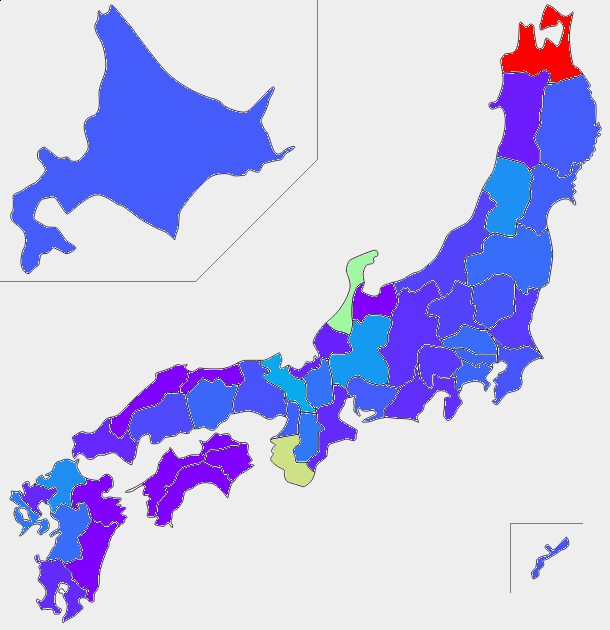

wrote to docs/images/japan-erns.jpg


In [25]:
tw_body_map_erns = "全国 新型コロナ情報 都道府県別 実効再生産数"
imgname = 'japan-erns.jpg'
make_japan_choropleth(imgname, tw_body_map_erns, latest_erns)
make_japan_heatmap(imgname, tw_body_map_erns, latest_erns, populations)

In [26]:
#tw_body_map_erns = "全国 新型コロナ情報 都道府県別 実効再生産数"
#mak_japan_heatmap('docs/images/japan-erns.jpg', tw_body_map_erns, latest_erns, populations)

wrote to docs/_includes/japan-1w.html



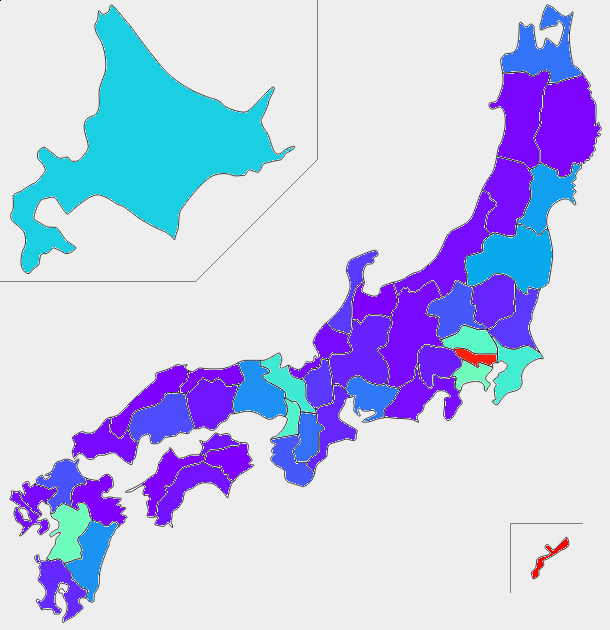

wrote to docs/images/japan-1w.jpg


In [27]:
tw_body_map_1w = "全国 新型コロナ情報 都道府県別 直近1週間罹患率"
imgname = 'japan-1w.jpg'
make_japan_choropleth(imgname, tw_body_map_1w, incid1w_rate)
make_japan_heatmap(imgname, tw_body_map_1w, incid1w_rate, populations)

wrote to docs/_includes/japan-2w.html



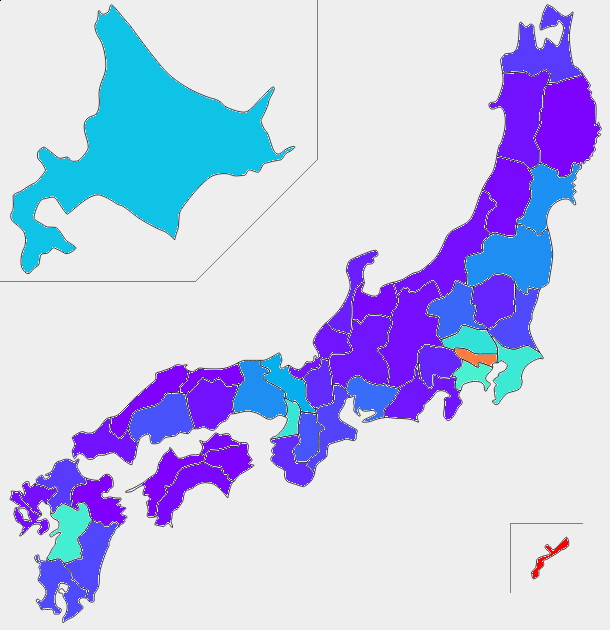

wrote to docs/images/japan-2w.jpg


In [28]:
tw_body_map_2w = "全国 新型コロナ情報 都道府県別 直近2週間罹患率"
imgname = 'japan-2w.jpg'
make_japan_choropleth(imgname, tw_body_map_2w, incid2w_rate)
make_japan_heatmap(imgname, tw_body_map_2w, incid2w_rate, populations)

wrote to docs/_includes/japan-all.html



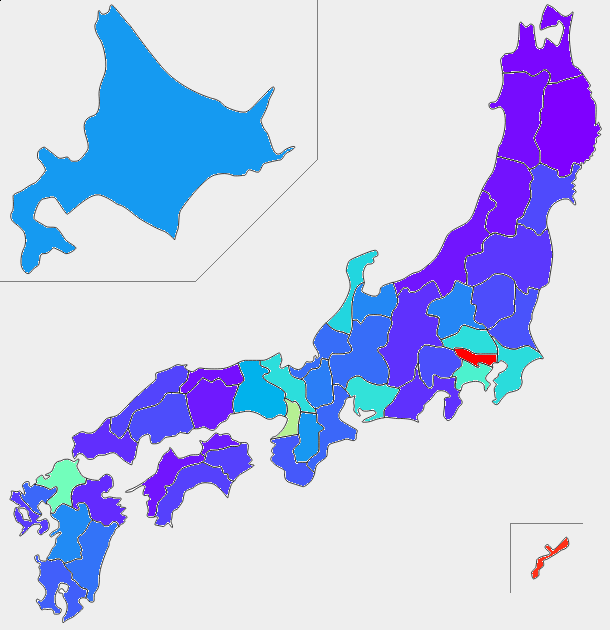

wrote to docs/images/japan-all.jpg


In [29]:
tw_body_map_all = "全国 新型コロナ情報 都道府県別 罹患率(全期間)"
imgname = 'japan-all.jpg'
make_japan_choropleth(imgname, tw_body_map_all, incid_all_rate)
make_japan_heatmap(imgname, tw_body_map_all, incid_all_rate, populations)

wrote to docs/_includes/japan-rate1w.html



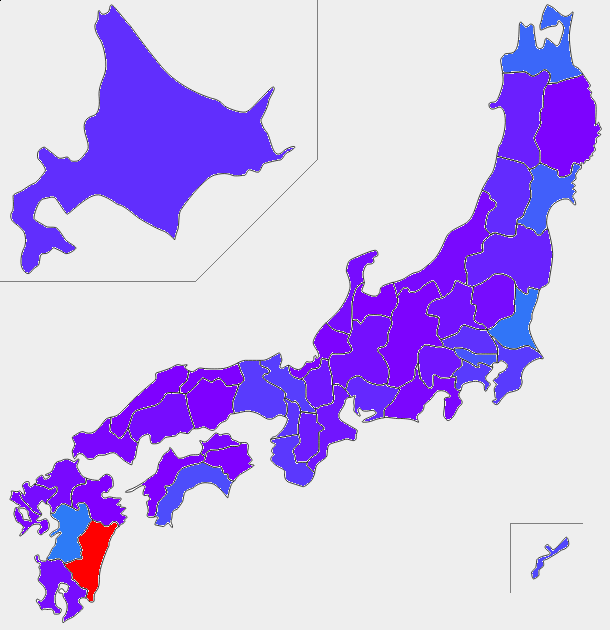

wrote to docs/images/japan-rate1w.jpg


In [30]:
tw_body_map_rate1w = "全国 新型コロナ情報 都道府県別 直近1週間陽性率"
imgname = 'japan-rate1w.jpg'
make_japan_choropleth(imgname, tw_body_map_rate1w, test1w_rate)
make_japan_heatmap(imgname, tw_body_map_rate1w, test1w_rate, populations)

wrote to docs/_includes/japan-rate2w.html



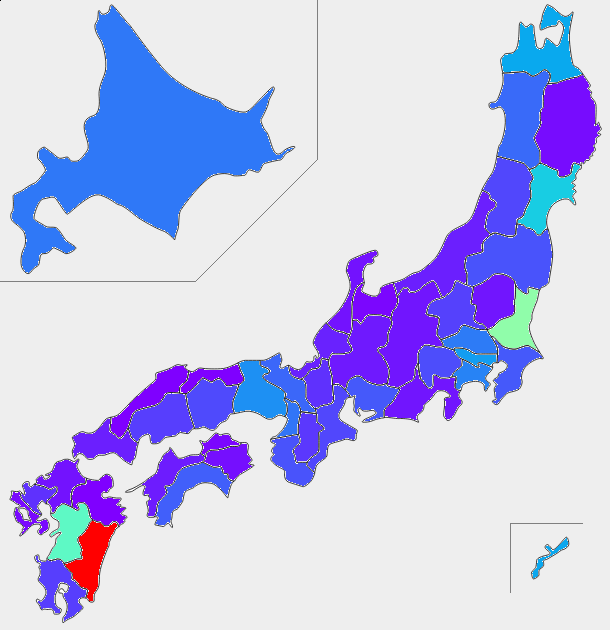

wrote to docs/images/japan-rate2w.jpg


In [31]:
tw_body_map_rate2w = "全国 新型コロナ情報 都道府県別 直近2週間陽性率"
imgname = 'japan-rate2w.jpg'
make_japan_choropleth(imgname, tw_body_map_rate2w, test2w_rate)
make_japan_heatmap(imgname, tw_body_map_rate2w, test2w_rate, populations)

In [32]:
tw = get_twitter()
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body_postfix = " https://geneasyura.github.io/cov19-hm/pref.html (東洋経済 " + today_str + " 現在)"
#tweet_with_image(tw, "images/ern-1w_poss.jpg", tw_body_1w + tw_body_postfix)
#tweet_with_image(tw, "images/ern-1w_poss-zoom.jpg", tw_body_1w_zoom + tw_body_postfix)
tweet_with_image(tw, "docs/images/ern-2w_poss.jpg", tw_body_2w + tw_body_postfix)
tweet_with_image(tw, "docs/images/ern-2w_poss-zoom.jpg", tw_body_2w_zoom + tw_body_postfix)

In [33]:
tweet_with_image(tw, 'docs/images/japan-erns.jpg', tw_body_map_erns + tw_body_postfix)
#tweet_with_image(tw, 'images/japan-1w.jpg', tw_body_map_1w + tw_body_postfix)
tweet_with_image(tw, 'docs/images/japan-2w.jpg', tw_body_map_2w + tw_body_postfix)
tweet_with_image(tw, 'docs/images/japan-all.jpg', tw_body_map_all + tw_body_postfix)

In [34]:
tweet_with_image(tw, 'docs/images/japan-rate1w.jpg', tw_body_map_rate1w + tw_body_postfix)
tweet_with_image(tw, 'docs/images/japan-rate2w.jpg', tw_body_map_rate2w + tw_body_postfix)